<a href="https://colab.research.google.com/github/StevenVuong/MSc_Project/blob/master/misc4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# ALL THE IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# other imports to handle files
import os
import pickle
import csv

# deep learning imports
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D, Convolution1D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils, generic_utils, to_categorical
from keras.layers import LeakyReLU
from keras import regularizers

# to split our dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# to mount our drive
from google.colab import drive

In [28]:
# MOUNT THE STORAGE
drive.mount('/content/gdrive')

os.chdir('/content')

# go to where we will be working
print (os.listdir())
os.chdir('gdrive/My Drive/msc_project/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['.config', 'gdrive', 'sample_data']


**Purpose of this notebook is to create metrics for our final presentation/graphs of everything we might need etc..**

In [0]:
# https://stackoverflow.com/questions/50920908/get-confusion-matrix-from-a-keras-multiclass-model
# Build confusion matrices for train and test data
# 3d is in Step3, need to run metrics on 4th batch of processed_brains_aug
# 2d is in misc3, need to run prediction metrics on 4th batch of processed_brains_aug also
# age/sex is in misc2 and runs off the larger dataset, pulling from the Control CSV.

Best models so far:
-  74.138% on the 3D brainscans, model 80
-  100% on the 2D brainscans(slice86), model keep100
-  76.667% on the Age/Sex values, each have a deep learning model
  

Metrics to present:
 <br>
-  Final accuracy and losses
-  Graphs of training accuracy and losses
-  Confusion Matrices
-  Deep learning architecture diagrams
-  Distrubition of population, age/sex


Information to gather:
<br>
-  Quality of each of the samples, where they came from. Distribution, sizes etc..

In [0]:
## Architecture Diagrams http://alexlenail.me/NN-SVG/AlexNet.html

 Attempt at confusion matrix here**
 <br>
Logic:
-  Load model, load the data for both train and test
-  Get true values, get predicted values for both train and test
-  Convert back to binary
-  Input into confusion matrix

In [0]:
def to_binary(cat_array):
  '''Function to convert categorical back to binary values'''
  binary_output_array = []
  for i in range(len(cat_array)):
    binary_output_array.append(np.argmax(cat_array[i]))
    
  binary_output_array = np.array(binary_output_array)
  return binary_output_array

In [0]:
def get_86_slice(ts):
  '''Gets the 86th slice and return this'''
  returned_array = []
  for ax_slice in total_slices:
    returned_array.append(ax_slice[86,:,:,0])
    
  returned_array = np.array(returned_array)
  return returned_array

In [0]:
# gets our y-values and converts to keras, one hot encoded outputs
def get_y_values(total_slices_info):
  
  y_values = [s[2] for s in total_slices_info]

  y_values = np.array(to_categorical(y_values, 2))
  
  return y_values

**BELOW IS FOR OUR 2D BRAINSCANS**

In [0]:
## Load our model, start with 100% accuracy model on the 2d scans
model_2dscans = pickle.load( open( "all_mprage_grappa/z_tests/keep_models/100Model(2dscans).pkl", "rb" ) )

In [98]:
## RUNNING THROUGH TRAINING DATA ##
## Loop through all our total slices and accumulate all the total slices info
training_batch_f = os.listdir('all_mprage_grappa/processed_brains_aug/')[:3]
print (training_batch_f)

# initialise our set of predicted outputs
y_train_real = []
y_train_preds = [] 
patient_train_info = []
# Just loop through once because we want to predict using our model only
for tbf in training_batch_f:
  with open('all_mprage_grappa/processed_brains_aug/'+tbf, 'rb') as f:
    total_slices, total_slices_info = pickle.load(f) 

  # get y values and process each slice
  y_values = get_y_values(total_slices_info)
  slices_86 = get_86_slice(total_slices) # get 86th slice
  slices_86 = np.expand_dims(slices_86, axis=3)

  # append patient information
  patient_train_info.extend(total_slices_info)

  # Make predictions on our slices
  train_predict = model_2dscans.predict(x=slices_86)
  y_train_preds.extend(train_predict)
  y_train_real.extend(y_values)
      
# set of batches that we will predict
patient_train_info = np.array(patient_train_info)
y_train_preds = np.array(y_train_preds)
y_train_real = np.array(y_train_real)

['dbatch0.pkl', 'dbatch1.pkl', 'dbatch2.pkl']


In [99]:
np.shape(patient_train_info)

(300, 4)

In [0]:
## RUNNING THROUGH TEST DATA ##
with open('all_mprage_grappa/processed_brains_aug/dbatch3.pkl', 'rb') as f:
  total_slices, total_slices_info = pickle.load(f) 

# get y values and process each slice
y_values = get_y_values(total_slices_info)
slices_86 = get_86_slice(total_slices) # get 86th slice
slices_86 = np.expand_dims(slices_86, axis=3)

# Turn into numpy arrays
y_test_preds = np.array(model_2dscans.predict(x=slices_86))
y_test_real = np.array(y_values)
patient_test_info = np.array(total_slices_info)

In [100]:
# turn into a dataframe
train_df = pd.DataFrame(patient_train_info)
train_df.columns=['ImageID', 'Gender', 'Group', 'Age']
train_df = train_df[::2] # take every second row (Because we have duplicates)

# turn age to integers
train_df['Age'] = train_df['Age'].astype(int)

train_df.head()

,ImageID,Gender,Group,Age
0,440184,F,1,56
2,417039,M,0,73
4,344401,M,0,68
6,269591,M,0,67
8,397621,M,1,63


In [101]:
# count number with PD and number of controls, 0 is Control, 1 is PD
np.unique(train_df.Group, return_counts=True) # 337 patients

(array(['0', '1'], dtype=object), array([63, 87]))

In [0]:
# establish control and pd df's
df_control = train_df[train_df.Group == '0'] # for control, keep duplicate subject n.o's
df_pd = train_df[train_df.Group == '1'] # so we keep duplicates for both groups anyhow

In [103]:
print ("Number of control patients: %d " % len(df_control))
print ("Number of PD patients: %d " % len(df_pd))

Number of control patients: 63 
Number of PD patients: 87 


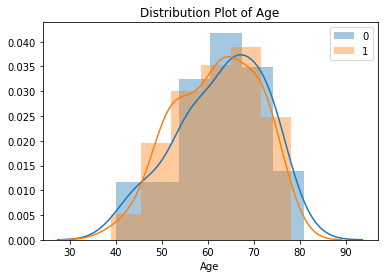

In [104]:
# seaborn distribution plot
sns.distplot(df_control.Age, rug=False, label='0')
sns.distplot(df_pd.Age, rug=False, label='1')
plt.title('Distribution Plot of Age')
plt.legend()
plt.show() # pd has a slightly older distribution than control

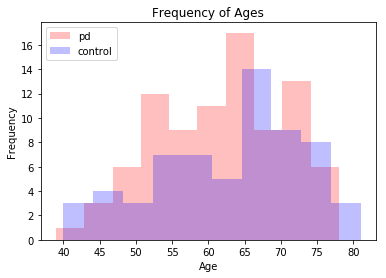

In [105]:
# plot for the ages
plt.hist(df_pd.Age, align='mid', alpha=0.25, color='r', label='pd', bins=10)
plt.hist(df_control.Age, align='mid', alpha=0.25, color='b', label='control', bins=10)
plt.legend(loc='upper left')

# set labels
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.title('Frequency of Ages')

# set ticks
plt.xticks(np.arange(min(df_control.Age), max(df_control.Age)+1, 5.0))
plt.show()

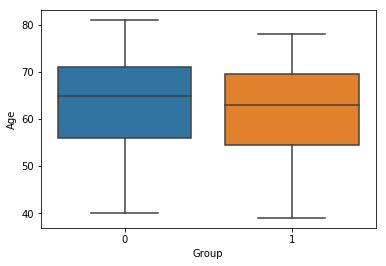

In [106]:
# some boxplots
ax = sns.boxplot(x="Group", y="Age", data=train_df)

In [107]:
print ("For Control:")
print (np.unique(df_control.Gender.values, return_counts=True))
print ("For PD")
print (np.unique(df_pd.Gender.values, return_counts=True)) # very visible from results males are more likely to get pd..

For Control:
(array(['F', 'M'], dtype=object), array([20, 43]))
For PD
(array(['F', 'M'], dtype=object), array([29, 58]))


In [110]:
# Turn to binary outputs
y_test_preds_binary = to_binary(y_test_preds)
y_test_real_binary = to_binary(y_test_real)

# MAKE CONFUSION MATRIX, can also do the same for train data
confusion_matrix(y_test_real_binary, y_test_preds_binary)

array([[36,  0],
       [ 0, 46]])

In [0]:
## Then test with /dbatch3.pkl

**BELOW IS FOR OUR 3D BRAINSCANS**

**BELOW IS FOR OUR AGE/SEX MODEL**